# From Square-Root Law to Dynamic Trade Effects

## 1. The dataset

From binance cryptocurrency api via the binance-LOB repository (https://github.com/pfei-sa/binance-LOB/tree/main)

Quotes data with a depth of 100 into the LOB timestamp, ask price, ask volume, bid price, bid volume, midpoint, spread

Trades data withtimestamp, price, volume, trade sign (-1 = sell, 1 = buy)

In [53]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
from scipy import stats 
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [54]:
trades_df = pd.concat([
    pd.read_csv(file, header=None, names=[
        'trade_id', 'price', 'volume', 'quote_volume', 
        'timestamp', 'is_buyer_maker', 'is_best_match'
    ]) for file in glob.glob(os.path.join("data/binance_raw", "BTCUSDT-trades*.csv"))
], ignore_index=True)

trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp'], unit='ns')
trades_df['price'] = trades_df['price'].astype(float)
trades_df['volume'] = trades_df['volume'].astype(float)
trades_df['trade_sign'] = trades_df['is_buyer_maker'].apply(lambda x: -1 if x else 1)
trades_df = trades_df.drop(columns=['is_buyer_maker', 'is_best_match'], axis=1)

print(trades_df.head())
print(trades_df.shape)
print(trades_df['volume'].min() , trades_df['volume'].max())

volumes = trades_df['volume']

print(f"     Median: {np.median(volumes):.6f} BTC")
print(f"     Zero volumes: {np.sum(volumes == 0)} ({100*np.mean(volumes == 0):.2f}%)")

median_volume = np.median(volumes[volumes > 0])
scale_factor = 1.0 / median_volume

trades_clean = trades_df.copy()
trades_clean['volume_normalized'] = trades_clean['volume'] * scale_factor
    
print("   Scale factor:", scale_factor)
print("   Normalized range:", trades_clean['volume_normalized'], trades_clean['volume_normalized'])
print("   Normalized median:", np.median(trades_clean['volume_normalized']))

ohlvc_df = pd.concat([
    pd.read_csv(file, header=None, names=[
                'open_time', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_volume', 'count', 'taker_buy_volume',
                'taker_buy_quote_volume', 'ignore'
    ]) for file in glob.glob(os.path.join("data/binance_raw", "BTCUSDT-1s*.csv"))
], ignore_index=True)

ohlvc_df['open_time'] = pd.to_datetime(ohlvc_df['open_time'], unit='ns')
ohlvc_df['close_time'] = pd.to_datetime(ohlvc_df['close_time'], unit='ns')
ohlvc_df['midpoint'] = (ohlvc_df['high'] + ohlvc_df['low'])/2
ohlvc_df['spread'] = 2 * (ohlvc_df['high'] - ohlvc_df['low'])

prices = trades_clean['price'].values
signs = trades_clean['trade_sign'].values
volumes = trades_clean['volume_normalized'].values

     trade_id      price   volume  quote_volume                     timestamp  \
0  5129304097  112546.35  0.00018     20.258343 1970-01-21 07:16:19.200039304   
1  5129304098  112546.35  0.00005      5.627318 1970-01-21 07:16:19.200046122   
2  5129304099  112546.35  0.00005      5.627318 1970-01-21 07:16:19.200046122   
3  5129304100  112546.35  0.00005      5.627318 1970-01-21 07:16:19.200046122   
4  5129304101  112546.35  0.00005      5.627318 1970-01-21 07:16:19.200046122   

   trade_sign  
0           1  
1           1  
2           1  
3           1  
4           1  
(7408539, 6)
1e-05 19.83132
     Median: 0.000050 BTC
     Zero volumes: 0 (0.00%)
   Scale factor: 20000.0
   Normalized range: 0          3.6
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
7408534    1.0
7408535    1.0
7408536    1.0
7408537    1.8
7408538    0.6
Name: volume_normalized, Length: 7408539, dtype: float64 0          3.6
1          1.0
2          1.0
3          1.0
4     

## 1. Baseline Implementation
- Square-Root Law: ΔP = Y σ√(Q/V)
- Parameter estimation and statistical validation
- Identify systematic deviations and failure modes

R(ℓ) measures how much, on average, the price moves up conditioned to a buy
order at time 0 (or a sell order moves the price down) a time ℓ later.

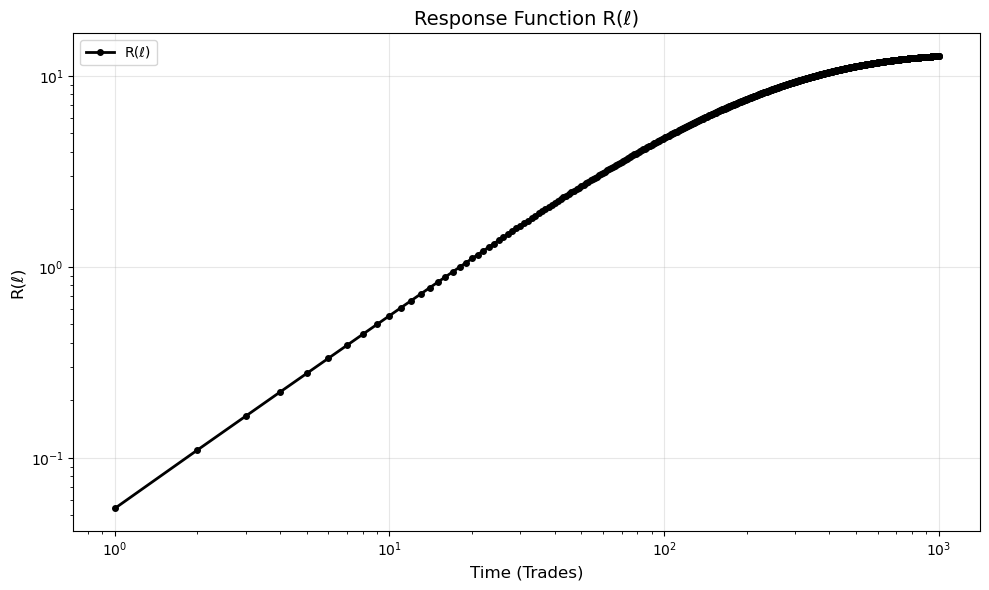

In [55]:
n_trades = len(prices)
max_lag = 1000
lags = np.arange(1, min(max_lag + 1, n_trades // 2))
response = np.zeros(len(lags))

for i, lag in enumerate(lags):
    price_diffs = prices[lag:] - prices[:-lag]
    trade_signs = signs[:-lag]
    
    response[i] = np.mean(price_diffs * trade_signs)

plt.figure(figsize=(10, 6))
plt.loglog(lags, response, 'ko-', linewidth=2, markersize=4, label='R(ℓ)')
plt.xlabel('Time (Trades)', fontsize=12)
plt.ylabel('R(ℓ)', fontsize=12)
plt.title('Response Function R(ℓ)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

7408539
7408539


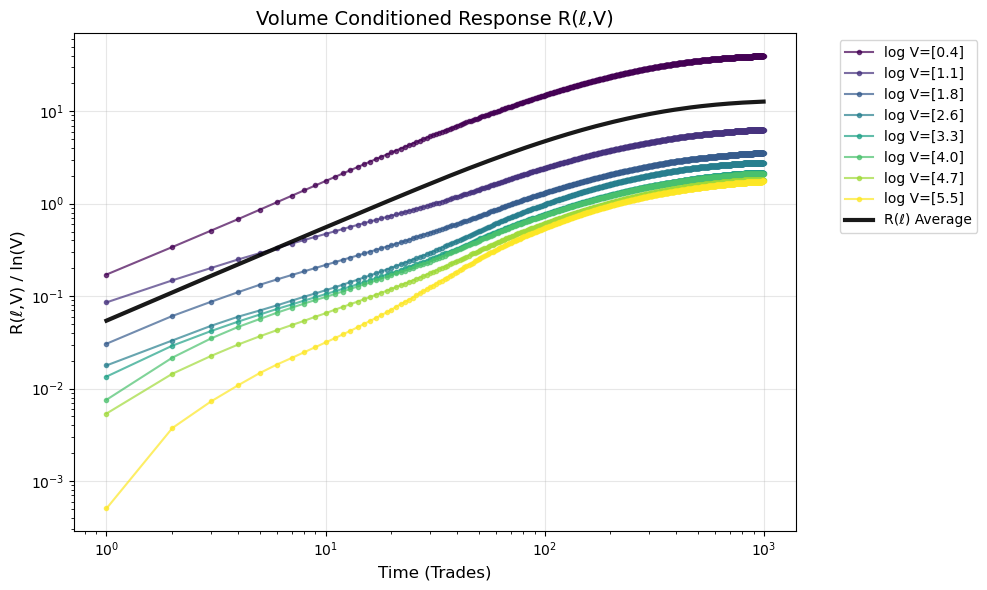

In [56]:
n_vol_bins = 8

# Log-spaced volume bins
log_vols = np.log(volumes[volumes > 0])
print(len(volumes))
print(len(log_vols))
vol_min, vol_max = np.percentile(log_vols, [5, 95])
vol_bins = np.logspace(vol_min, vol_max, n_vol_bins + 1, base=np.e)

response_matrix = np.full((len(lags), n_vol_bins), np.nan)
vol_centers = np.zeros(n_vol_bins)

for vol_idx in range(n_vol_bins):
    # Find trades in this volume bin
    vol_mask = (volumes >= vol_bins[vol_idx]) & (volumes < vol_bins[vol_idx + 1])
    vol_centers[vol_idx] = np.sqrt(vol_bins[vol_idx] * vol_bins[vol_idx + 1])
    
    if np.sum(vol_mask) < 50:  # Skip bins with few trades
        continue
    
    vol_indices = np.where(vol_mask)[0]
    
    for i, lag in enumerate(lags):
        valid_indices = vol_indices[vol_indices < n_trades - lag]
        
        if len(valid_indices) < 10:
            continue
            
        # response
        price_diffs = prices[valid_indices + lag] - prices[valid_indices]
        trade_signs = signs[valid_indices]
        response_matrix[i, vol_idx] = np.mean(price_diffs * trade_signs)

vol_data = {
    'lags': lags,
    'vol_centers': vol_centers,
    'vol_bins': vol_bins,
    'response_matrix': response_matrix,
    'log_vol_centers': np.log(vol_centers)
}


plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(vol_data['vol_centers'])))

for vol_idx, (vol_center, color) in enumerate(zip(vol_data['vol_centers'], colors)):
    response_vol = vol_data['response_matrix'][:, vol_idx]
    valid_mask = ~np.isnan(response_vol)
    
    if np.sum(valid_mask) > 10:  # Only plot if enough data points
        log_vol = np.log(vol_center)
        label = f'log V=[{log_vol:.1f}]'
        
        # Apply factorization scaling: divide by ln(V) for data collapse
        scaled_response = response_vol / np.log(vol_center)
        
        plt.loglog(lags[valid_mask], scaled_response[valid_mask], 
                    'o-', color=color, linewidth=1.5, markersize=3,
                    alpha=0.7, label=label)

# Add average R(l) to right panel for comparison
plt.loglog(lags, response, 'k-', linewidth=3, label='R(ℓ) Average', alpha=0.9)

plt.xlabel('Time (Trades)', fontsize=12)
plt.ylabel('R(ℓ,V) / ln(V)', fontsize=12)
plt.title('Volume Conditioned Response R(ℓ,V)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()


In [57]:
mean_log_vol = np.mean(log_vols)
mean_sign = np.mean(signs)
mean_sign_squared = mean_sign**2

C0 = np.zeros(len(lags))  # Basic sign correlation
C1 = np.zeros(len(lags))  # Cross correlation with volume
C2 = np.zeros(len(lags))  # Volume-weighted correlation

for i, lag in enumerate(lags):
    print(f"  Lag {lag}/{max_lag}")
        
    idx_present = slice(None, -lag)  # [0, 1, ..., n-lag-1]  
    idx_future = slice(lag, None)    # [lag, lag+1, ..., n-1]
    
    signs_present = signs[idx_present]
    signs_future = signs[idx_future] 
    log_vols_present = log_vols[idx_present]
    log_vols_future = log_vols[idx_future]
    
    # C0(l) = <ε_{n+l} ε_n> - <ε_n>²
    C0[i] = np.mean(signs_future * signs_present) - mean_sign_squared
    
    # C1(l) = <ε_{n+l} ε_n ln V_n>
    C1[i] = np.mean(signs_future * signs_present * log_vols_present)
    
    # C2(l) = <ε_{n+l} ln V_{n+l} ε_n ln V_n>
    C2[i] = np.mean(signs_future * log_vols_future * signs_present * log_vols_present)

correlations = {
    'lags': lags,
    'C0': C0,
    'C1': C1, 
    'C2': C2,
    'mean_log_vol': mean_log_vol
}

  Lag 1/1000
  Lag 2/1000
  Lag 3/1000
  Lag 4/1000
  Lag 5/1000
  Lag 6/1000
  Lag 7/1000
  Lag 8/1000
  Lag 9/1000
  Lag 10/1000
  Lag 11/1000
  Lag 12/1000
  Lag 13/1000
  Lag 14/1000
  Lag 15/1000
  Lag 16/1000
  Lag 17/1000
  Lag 18/1000
  Lag 19/1000
  Lag 20/1000
  Lag 21/1000
  Lag 22/1000
  Lag 23/1000
  Lag 24/1000
  Lag 25/1000
  Lag 26/1000
  Lag 27/1000
  Lag 28/1000
  Lag 29/1000
  Lag 30/1000
  Lag 31/1000
  Lag 32/1000
  Lag 33/1000
  Lag 34/1000
  Lag 35/1000
  Lag 36/1000
  Lag 37/1000
  Lag 38/1000
  Lag 39/1000
  Lag 40/1000
  Lag 41/1000
  Lag 42/1000
  Lag 43/1000
  Lag 44/1000
  Lag 45/1000
  Lag 46/1000
  Lag 47/1000
  Lag 48/1000
  Lag 49/1000
  Lag 50/1000
  Lag 51/1000
  Lag 52/1000
  Lag 53/1000
  Lag 54/1000
  Lag 55/1000
  Lag 56/1000
  Lag 57/1000
  Lag 58/1000
  Lag 59/1000
  Lag 60/1000
  Lag 61/1000
  Lag 62/1000
  Lag 63/1000
  Lag 64/1000
  Lag 65/1000
  Lag 66/1000
  Lag 67/1000
  Lag 68/1000
  Lag 69/1000
  Lag 70/1000
  Lag 71/1000
  Lag 72/1000
 

In [58]:
def power_law(x: np.ndarray, A: float, gamma: float) -> np.ndarray:
    """Power law function: A * x^(-gamma)"""
    return A * np.power(x, -gamma)

In [59]:
min_lag = 10

mask = (correlations['lags'] >= min_lag) & (correlations['lags'] <= max_lag) & (correlations['C0'] > 0)

# Linear fit: log(y) = log(A) - gamma * log(x)
if np.sum(mask) > 5:
    log_lags = np.log(lags[mask])
    log_corr = np.log(correlations['C0'][mask])
    
    # Ajustement linéaire en log-log
    coeffs = np.polyfit(log_lags, log_corr, 1)
    gamma = -coeffs[0]  # Pente négative → exposant positif
    A = np.exp(coeffs[1])
    
    print(f"Ajustement C₀(ℓ) ∝ ℓ^(-{gamma:.3f})")

Ajustement C₀(ℓ) ∝ ℓ^(-0.803)


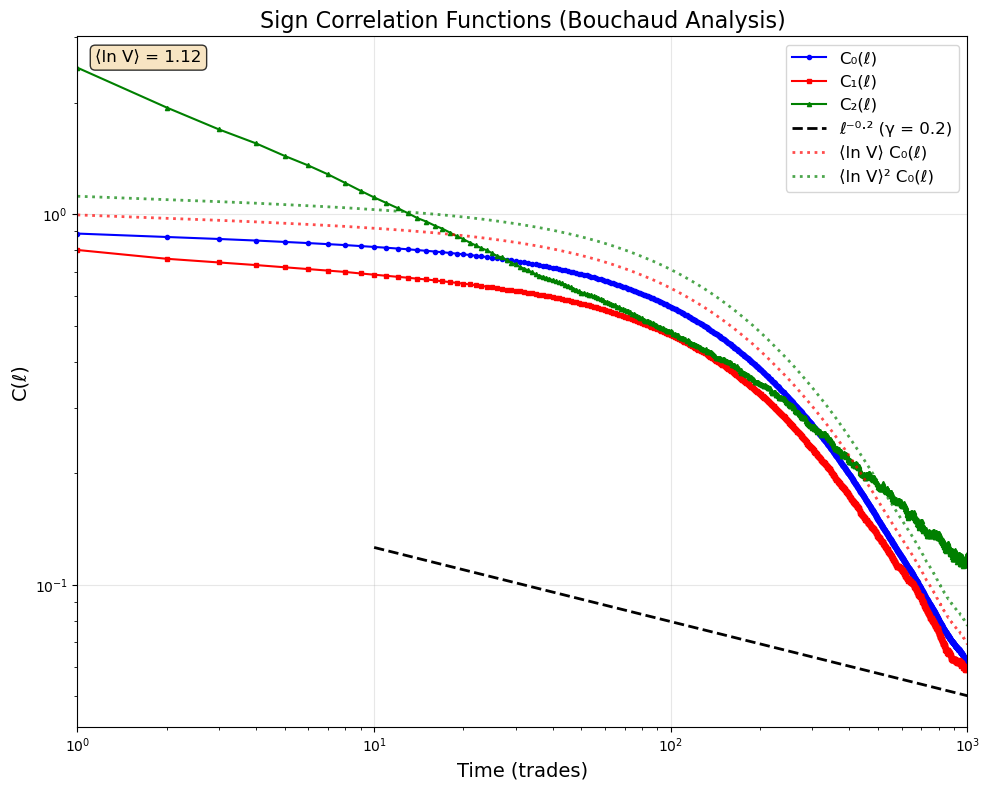

In [63]:
# Simple correlation functions plot
fig, ax = plt.subplots(figsize=(10, 8))

# Extract data
lags = correlations['lags']
C0 = correlations['C0'] 
C1 = correlations['C1']
C2 = correlations['C2']
mean_log_vol = correlations['mean_log_vol']

# Plot the three correlation functions
ax.loglog(lags, C0, 'o-', label='C₀(ℓ)', color='blue', markersize=3, linewidth=1.5)
ax.loglog(lags, np.abs(C1), 's-', label='C₁(ℓ)', color='red', markersize=3, linewidth=1.5)  
ax.loglog(lags, C2, '^-', label='C₂(ℓ)', color='green', markersize=3, linewidth=1.5)

# Simple power law reference line (γ = 0.2)
ref_lags = np.logspace(1, 3, 50)
ref_line = 0.2 * ref_lags**(-0.2)  # Simple power law
ax.loglog(ref_lags, ref_line, 'k--', linewidth=2, label='ℓ⁻⁰·² (γ = 0.2)')

# Theoretical relationships from Bouchaud
theoretical_C1 = mean_log_vol * C0
theoretical_C2 = mean_log_vol**2 * C0

# Plot theoretical lines
valid_mask = C0 > 0
ax.loglog(lags[valid_mask], np.abs(theoretical_C1[valid_mask]), ':', 
         color='red', alpha=0.7, linewidth=2, label='⟨ln V⟩ C₀(ℓ)')
ax.loglog(lags[valid_mask], theoretical_C2[valid_mask], ':', 
         color='green', alpha=0.7, linewidth=2, label='⟨ln V⟩² C₀(ℓ)')

# Labels and formatting
ax.set_xlabel('Time (trades)', fontsize=14)
ax.set_ylabel('C(ℓ)', fontsize=14) 
ax.set_title('Sign Correlation Functions (Bouchaud Analysis)', fontsize=16)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)
ax.set_xlim(1, max(lags))

# Statistics box
textstr = f'⟨ln V⟩ = {mean_log_vol:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

## 2. Propagator Model
- Propagator Model: P(t) = ∑G(t-s)ε(s)
- Temporal impact analysis (temporary vs permanent)
- Trade information content effects

In [61]:
# P(t) = Σ G₀(t-s) ε(s) ln(V(s))
def propagator_function(t, t0=20, beta=0.4, Gamma0=0.001):
    """G₀(t) = Γ₀ * t₀^β / (t₀ + t)^β"""
    return Gamma0 * (t0**beta) / ((t0 + t)**beta)

# Theoretical response function
def theoretical_response(lags, C0, gamma, t0=20, beta=0.4, Gamma0=0.001):
    """R(ℓ) using Eq. 17 from the paper"""
    R_theory = []
    
    for lag in lags:
        # Direct term
        term1 = propagator_function(lag, t0, beta, Gamma0)
        
        # Correlation terms
        term2 = 0
        for n in range(1, min(lag, 100)):
            if n < len(correlations):
                corr = C0 / (n**gamma) if n > 0 else C0
                term2 += propagator_function(lag - n, t0, beta, Gamma0) * corr
        
        R_theory.append(term1 + term2)
    
    return np.array(R_theory)

def fit_propagator(params):
    t0, beta, Gamma0 = params
    if beta <= 0 or beta >= 1 or t0 <= 0 or Gamma0 <= 0:
        return 1e6
    
    R_pred = theoretical_response(lags[:len(response)], C0, gamma, t0, beta, Gamma0)
    return np.sum((response - R_pred)**2)

Mean reversion: 

- β >> β_critical indicates a strong anti-persistance. The impact of trades decays immediatly.
- β << β_critical indicates a strong persistance. Trades have a long term impact.

In [62]:
# Initial guess: critical condition β = (1-γ)/2
beta_critical = (1 - gamma) / 2
result = minimize(fit_propagator, [20, beta_critical, 0.001], 
                 bounds=[(1, 100), (0.1, 0.9), (1e-6, 0.1)])

t0_fit, beta_fit, Gamma0_fit = result.x
print(f"Fitted: t₀={t0_fit:.1f}, β={beta_fit:.3f}, Γ₀={Gamma0_fit:.6f}")
print(f"Critical β = {beta_critical:.3f}")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1000,) + inhomogeneous part.

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Trade sign correlations
ax1.loglog(lags[valid], correlations[valid], 'o', markersize=2)
ax1.loglog(lags[valid], C0 / lags[valid]**gamma, 'r-')
ax1.set_xlabel('Lag ℓ')
ax1.set_ylabel('C₀(ℓ)')
ax1.set_title(f'Trade Sign Correlation (γ={gamma:.3f})')
ax1.grid(True, alpha=0.3)

# Response function
R_fitted = theoretical_response(lags[:len(response)], C0, gamma, t0_fit, beta_fit, Gamma0_fit)
ax2.plot(lags[:len(response)], response, 'o', markersize=1, label='Empirical')
ax2.plot(lags[:len(response)], R_fitted, 'r-', label='Fitted')
ax2.set_xlabel('Lag ℓ')
ax2.set_ylabel('R(ℓ)')
ax2.set_title('Response Function')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Propagator function
t_range = np.logspace(0, 3, 100)
G0_values = [propagator_function(t, t0_fit, beta_fit, Gamma0_fit) for t in t_range]
ax3.loglog(t_range, G0_values)
ax3.set_xlabel('Time lag')
ax3.set_ylabel('G₀(t)')
ax3.set_title(f'Propagator Function (β={beta_fit:.3f})')
ax3.grid(True, alpha=0.3)

# Price series sample
ax4.plot(prices[:500])
ax4.set_xlabel('Time')
ax4.set_ylabel('Price')
ax4.set_title('Price Series (sample)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. ML Implementation
- Features: Volatility metrics, volume patterns, spreads, order book imbalance, decay patterns from propagator analysis
- Target: Direct price impact ΔP prediction
- Models: Compare ML predictions vs Square-root law vs Propagator model

In [ ]:
# compute midpoint and spread for trades_df (match timestamps with ohlcv)

In [ ]:
def create_features(trades_df, lookback=20):
    """Simple feature creation"""
    features = []
    
    for i in range(lookback, len(trades_df)-10):
        window = trades_df.iloc[i-lookback:i]
        current_trade = trades_df.iloc[i]
        
        # Basic features
        feature_row = {
            # Current trade
            'volume': current_trade['volume'],
            'log_volume': np.log(current_trade['volume']),
            'trade_sign': current_trade['trade_sign'],
            'spread': current_trade['spread'],
            
            # Historical patterns (lookback window)
            'avg_volume': window['volume'].mean(),
            'vol_ratio': current_trade['volume'] / window['volume'].mean(),
            'price_volatility': window['price'].pct_change().std(),
            'avg_spread': window['spread'].mean(),
            'sign_imbalance': window['epsilon'].mean(),
            
            # Target variable (price impact over next 10 trades)
            'price_impact': ((trades_df['price'].iloc[i+10] - trades_df['price'].iloc[i]) 
                           * current_trade['epsilon'] / trades_df['price'].iloc[i])
        }
        
        features.append(feature_row)
    
    return pd.DataFrame(features)

df = create_features(trades_df)


In [ ]:
feature_cols = ['volume', 'log_volume', 'trade_sign', 'spread', 'avg_volume', 
                'vol_ratio', 'price_volatility', 'avg_spread', 'sign_imbalance']

X = df[feature_cols]
y = df['price_impact']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

print("Features prepared and scaled")
print(f"X shape: {X_scaled.shape}")
print(f"y shape: {y.shape}")


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, shuffle=False  # Don't shuffle for time series
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Random forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


In [ ]:
# ΔP = Y * σ * sqrt(Q/V) * sign

Y_param = 0.1  # This should come from your Phase 1 calibration

# Calculate baseline predictions
baseline_pred = []
for i in range(len(X_test)):
    Q = X_test['volume'].iloc[i]
    V = X_test['avg_volume'].iloc[i] 
    sigma = X_test['price_volatility'].iloc[i]
    sign = X_test['trade_sign'].iloc[i]
    
    sqrt_impact = Y_param * sigma * np.sqrt(Q / V) * sign
    baseline_pred.append(sqrt_impact)

baseline_pred = np.array(baseline_pred)
print("Square-Root Law baseline calculated")


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  R²: {r2:.4f}")
    return mse, r2

print("Model Performance:")
print("="*50)

lr_mse, lr_r2 = evaluate_model(y_test, lr_pred, "Linear Regression")
rf_mse, rf_r2 = evaluate_model(y_test, rf_pred, "Random Forest")
bl_mse, bl_r2 = evaluate_model(y_test, baseline_pred, "Square-Root Law")


In [ ]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (Random Forest):")
print(feature_importance)


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Feature importance
axes[0,0].barh(feature_importance['feature'], feature_importance['importance'])
axes[0,0].set_title('Feature Importance')
axes[0,0].set_xlabel('Importance')

# Model comparison
models = ['Linear Reg', 'Random Forest', 'Square-Root Law']
mse_scores = [lr_mse, rf_mse, bl_mse]
r2_scores = [lr_r2, rf_r2, bl_r2]

axes[0,1].bar(models, mse_scores)
axes[0,1].set_title('Model Comparison (MSE)')
axes[0,1].set_ylabel('MSE')
axes[0,1].tick_params(axis='x', rotation=45)

# Predictions vs actual
axes[1,0].scatter(y_test[:100], rf_pred[:100], alpha=0.6, label='Random Forest')
axes[1,0].scatter(y_test[:100], baseline_pred[:100], alpha=0.6, label='Square-Root Law')
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1,0].set_xlabel('Actual Impact')
axes[1,0].set_ylabel('Predicted Impact')
axes[1,0].set_title('Predictions vs Actual (First 100 samples)')
axes[1,0].legend()

# Residuals
residuals_rf = y_test - rf_pred
axes[1,1].scatter(rf_pred, residuals_rf, alpha=0.6)
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_xlabel('Predicted Impact')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residuals Plot (Random Forest)')

plt.tight_layout()
plt.show()

## 4. Regime-Dependent Analysis
- Identify market conditions where traditional models underperform
- Cross-validation framework across different market regimes
- Performance comparison metrics focusing on model failure cases